In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import geopandas as gpd
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import shapely

In [3]:
# Load gexf files
camion = nx.read_gexf('red_transporte-publico.gexf')
carro = nx.read_gexf('red-vialidades.gexf')

In [4]:
# Load trips
traslados_complete = pd.read_csv('Day0_Full_Filtered.csv')
traslados_origen = gpd.read_file('Day0_FiltCent_origin.geojson')
traslados_destino = gpd.read_file('Day0_FiltCent_destination.geojson')

# Get distance in km per trip as separate dataset
distances = []
for i in range(len(traslados_origen)):
    lat_origen = traslados_origen.geometry[i].y
    lon_origen = traslados_origen.geometry[i].x
    lat_destino = traslados_destino.geometry[i].y
    lon_destino = traslados_destino.geometry[i].x
    
    d = ((lat_destino - lat_origen) * 111139)**2 + ((lon_destino - lon_origen) * 111139)**2
    distances.append(np.sqrt(d))

**Suposición:** Todos los viajes menores a 0.5 km se realizan a pie o bicicleta (18%)

In [5]:
traslados = traslados_complete.copy()

traslados['distance'] = distances
traslados = traslados[traslados['distance'] > 500]

In [6]:
# Split trips into two datasets: 60% for one and 40% for the other
traslados_particular = traslados.sample(frac=0.6, random_state=37)
traslados_publico = traslados.drop(traslados_particular.index)

In [7]:
roadintersections = pd.read_csv('intersections_bysector.csv')
publicintersections = pd.read_csv('intersections_publico_bysector.csv')

In [8]:
def find_route(G, start_node, end_node):
    try:
        # Find shortest path based on nodes
        path = nx.shortest_path(G, source=start_node, target=end_node, weight='length')
        
        # Track the road names used along the path
        route = []
        road_route = []
        current_road = G.edges[path[0], path[1]]['road']
        segment = [path[0]]  # Initialize with the start node
        
        for i in range(1, len(path)):
            edge_road = G.edges[path[i-1], path[i]]['road']
            if edge_road != current_road:
                # Add the completed segment to the route
                segment.append(path[i-1])
                route.append((current_road, segment))
                road_route.append(current_road)
                
                # Start a new segment on a different road
                current_road = edge_road
                segment = [path[i-1]]
                
            segment.append(path[i])
        
        # Add the final segment to the route
        route.append((current_road, segment))
        road_route.append(current_road)
        
        return road_route, route
    
    except nx.NetworkXNoPath:
        return f"No route found from {start_node} to {end_node}."

In [9]:
trips_1 = traslados_particular.copy()
trips_1 = trips_1.reset_index(drop=True)
trips_1 = trips_1[['h3_origin', 'h3_destination', 'hour_origin', 'dsemana_origin', 'count', 'distance']]
trips_1['fullpath'] = None
trips_1['roadpath'] = None

for i in range(len(trips_1)):
    origen = trips_1['h3_origin'][i]
    destino = trips_1['h3_destination'][i]

    if origen not in carro.nodes or destino not in carro.nodes:
        trips_1['fullpath'][i] = None
        trips_1['roadpath'][i] = None
        continue
    
    # Find the route between origin and destination
    roads, route = find_route(carro, origen, destino)
    trips_1['fullpath'][i] = route
    trips_1['roadpath'][i] = roads

In [10]:
trips_2 = traslados_publico.copy()
trips_2 = trips_2.reset_index(drop=True)
trips_2 = trips_2[['h3_origin', 'h3_destination', 'hour_origin', 'dsemana_origin', 'count', 'distance']]
trips_2['fullpath'] = None
trips_2['roadpath'] = None

for i in range(len(trips_2)):
    origen = trips_2['h3_origin'][i]
    destino = trips_2['h3_destination'][i]
    
    if origen not in camion.nodes or destino not in camion.nodes:
        trips_2['fullpath'][i] = None
        trips_2['roadpath'][i] = None
        continue

    # Find the route between origin and destination
    roads, route = find_route(camion, origen, destino)
    trips_2['fullpath'][i] = route
    trips_2['roadpath'][i] = roads

In [11]:
trips_1['passengers'] = None

for i in range(len(trips_1)):
    val = random.random()
    if val < 0.614:
        trips_1['passengers'][i] = 1
    elif val >= 0.614 and val < 0.898:
        trips_1['passengers'][i] = 2
    elif val >= 0.898 and val < 0.965:
        trips_1['passengers'][i] = 3
    elif val >= 0.965 and val < 0.987:
        trips_1['passengers'][i] = 4
    else:
        trips_1['passengers'][i] = 5

In [12]:
path_trips_1 = trips_1.copy()
# Remove null paths
path_trips_1 = path_trips_1[path_trips_1['roadpath'].notnull()]
# Filter out trips with road path shorter than 2
path_trips_1 = path_trips_1[path_trips_1['roadpath'].apply(lambda x: len(x) > 2)]

path_trips_1['roadpath'] = path_trips_1['roadpath'].apply(lambda x: str(x))
path_trips_1.groupby(str('roadpath')).agg({'count': 'sum'}).reset_index().sort_values('count', ascending=False)

,roadpath,count
678,"['Ignacio Zaragoza', 'Av. Constitución', 'Flor...",89
544,"['Florencio Antillón', 'Av. Constitución', 'Ig...",77
675,"['Ignacio Zaragoza', 'Av. Constitución', 'Av. ...",54
398,"['Av. Venustiano Carranza', 'Av. Cristóbal Col...",51
350,"['Av. Simón Bolivar', 'Av. Adolfo Ruiz Cortine...",51
...,...,...
768,"['Jordán', 'Av. Francisco I. Madero', 'Av. Dr....",1
765,"['Jordán', 'Av. Francisco I. Madero', 'Antonio...",1
762,"['Jordán', 'Av. Cristóbal Colón', 'Ignacio Zar...",1
755,"['Jordán', 'Av. Adolfo Ruiz Cortines', 'Nevado...",1


In [13]:
trips_2['passengers'] = None

for i in range(len(trips_2)):
    trips_2['passengers'] = np.ceil(random.random() * 30)

In [14]:
# Get the number of trips per path, per hour, per day and multiply by count
trips1 = trips_1.copy()
trips2 = trips_2.copy()

# Separate the roadpath into individual roads and save as separate rows
trips1 = trips1.explode('roadpath')
trips2 = trips2.explode('roadpath')

# Get the number of trips per roadpath and hour, multiply by count
summary_bytrips_1 = trips1.groupby(['roadpath', 'hour_origin']).agg({'count': 'sum'}).reset_index()
summary_bytrips_2 = trips2.groupby(['roadpath', 'hour_origin']).agg({'count': 'sum'}).reset_index()

# Get the number of passengers per roadpath and hour, multiply by count
summary_bypassengers_1 = trips1.groupby(['roadpath', 'hour_origin']).agg({'count': 'sum', 'passengers': 'sum'}).reset_index()
summary_bypassengers_2 = trips2.groupby(['roadpath', 'hour_origin']).agg({'count': 'sum', 'passengers': 'sum'}).reset_index()

## ""Simulación"" de traslados

In [15]:
# Summarise the number of trips per road
summary_bytrips_1.groupby('roadpath').agg({'count': 'sum'}).reset_index().sort_values('count', ascending=False).head(10)

,roadpath,count
10,Av. Francisco I. Madero,7092
7,Av. Cristóbal Colón,5111
15,Av. Pino Suárez,3345
64,Washington,3074
62,Vicente Guerrero,2864
33,Ignacio Zaragoza,2577
4,Av. Benito Juárez,2392
55,Profesor José Silvestre Aramberri,2375
19,Av. Venustiano Carranza,2251
28,Fray Servando Padre Mier,2213


In [16]:
red_vial = gpd.read_file('data_transporte_inside.geojson')
red_publico = gpd.read_file('transportepublico_inside.geojson')

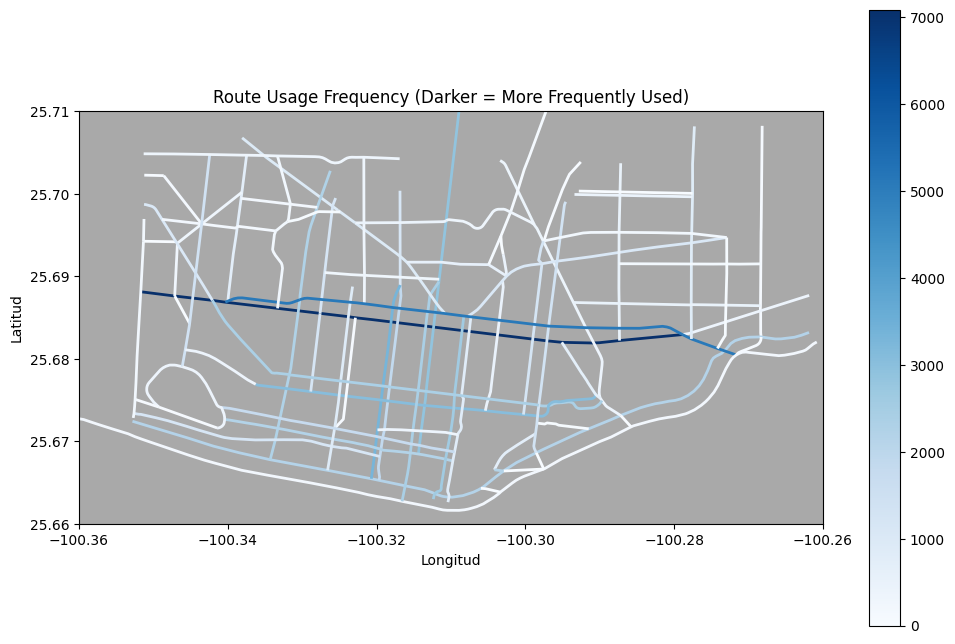

In [17]:
usage_summary = summary_bytrips_1.groupby('roadpath')['count'].sum().reset_index()

# Merge the aggregated usage data with 'transporte' on route names
transporte1 = red_vial.merge(usage_summary, left_on='nombre', right_on='roadpath', how='left')

# Step 3: Plot the routes with color determined by usage frequency
# Normalize the 'count' column for color mapping
transporte1['count'] = transporte1['count'].fillna(0)  # Fill any missing counts with 0
vmin, vmax = transporte1['count'].min(), transporte1['count'].max()

fig, ax = plt.subplots(figsize=(12, 8))
transporte1.plot(column='count', cmap='Blues', linewidth=2, ax=ax, legend=True, vmin=vmin, vmax=vmax)
plt.title("Route Usage Frequency (Darker = More Frequently Used)")
ax.set_facecolor('darkgrey')

ax.set_xlabel("Longitud")
ax.set_xlim(-100.36, -100.26)
ax.set_ylabel("Latitud")
ax.set_ylim(25.66, 25.71)

plt.show()

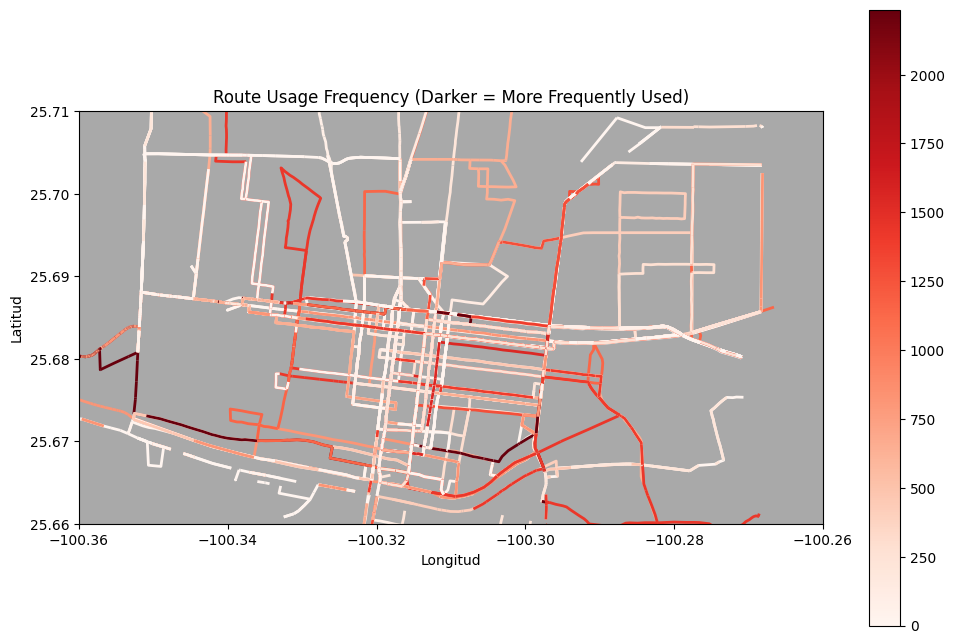

In [18]:
usage_summary = summary_bytrips_2.groupby('roadpath')['count'].sum().reset_index()

# Merge the aggregated usage data with 'transporte' on route names
transporte2 = red_publico.merge(usage_summary, left_on='nombre', right_on='roadpath', how='left')

# Step 3: Plot the routes with color determined by usage frequency
# Normalize the 'count' column for color mapping
transporte2['count'] = transporte2['count'].fillna(0)  # Fill any missing counts with 0
vmin, vmax = transporte2['count'].min(), transporte2['count'].max()

fig, ax = plt.subplots(figsize=(12, 8))
transporte2.plot(column='count', cmap='Reds', linewidth=2, ax=ax, legend=True, vmin=vmin, vmax=vmax)
plt.title("Route Usage Frequency (Darker = More Frequently Used)")
ax.set_facecolor('darkgrey')

ax.set_xlabel("Longitud")
ax.set_xlim(-100.36, -100.26)
ax.set_ylabel("Latitud")
ax.set_ylim(25.66, 25.71)

plt.show()

In [19]:
summary_bytrips_2.groupby('roadpath').agg({'count': 'sum'}).reset_index().sort_values('count', ascending=False).head(10)

,roadpath,count
50,69,2236
56,77,1553
43,42,1428
44,46,1426
52,70C,1390
57,86,1387
49,67,1280
13,15ER,1148
24,226,1142
47,6,824


In [20]:
centromty_polygon = shapely.Polygon([
    (-100.351,25.705),
    (-100.353,25.671),
    (-100.307,25.662),
    (-100.278,25.673),
    (-100.268,25.683),
    (-100.268,25.703)
])

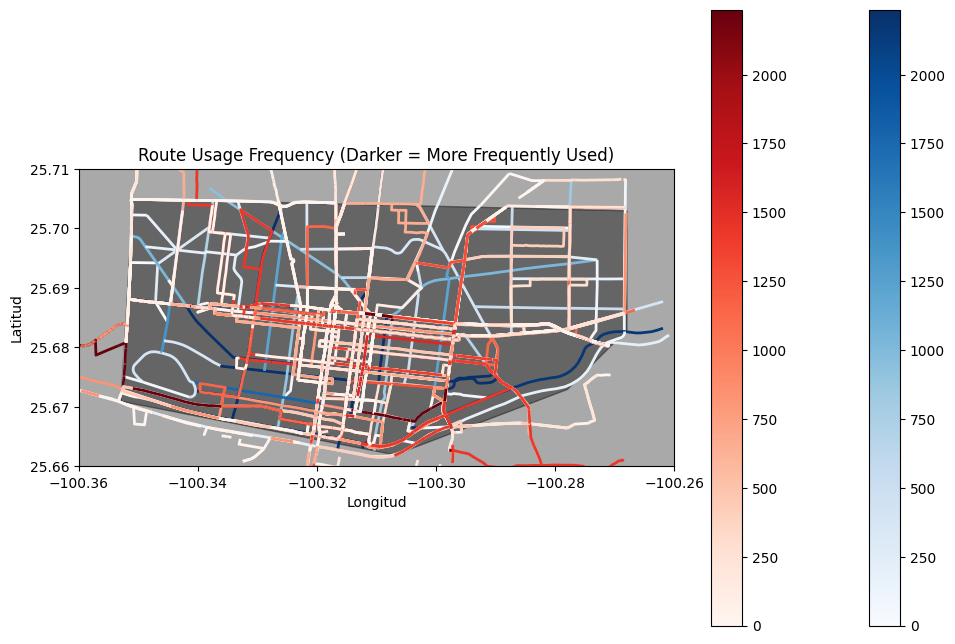

In [21]:
# Show both plots together in the same plot
fig, ax = plt.subplots(figsize=(12, 8))
transporte1.plot(column='count', cmap='Blues', linewidth=2, ax=ax, legend=True, vmin=vmin, vmax=vmax)
transporte2.plot(column='count', cmap='Reds', linewidth=2, ax=ax, legend=True, vmin=vmin, vmax=vmax)
# Include the city center polygon on top of 
gpd.GeoSeries([centromty_polygon]).plot(ax=ax, color='black', edgecolor='black', alpha=0.4)

plt.title("Route Usage Frequency (Darker = More Frequently Used)")
ax.set_facecolor('darkgrey')

ax.set_xlabel("Longitud")
ax.set_xlim(-100.36, -100.26)
ax.set_ylabel("Latitud")
ax.set_ylim(25.66, 25.71)

plt.show()


In [22]:
print(red_vial['nombre'].unique())

['Av. Churubusco' 'Av. Alfonso Reyes' 'Av. Prolongación Madero'
 'Av. Constitución' 'Av. Francisco I. Madero' 'Av. Cristóbal Colón'
 'Cuauhtémoc' 'Av. Dr. Ignacio Morones Prieto' 'Fundidora'
 'Av. José María Luis Mora' 'Av. Venustiano Carranza'
 'José Ángel Conchello' 'Vicente Guerrero' 'Av. Pino Suárez'
 'Profesor José Silvestre Aramberri' 'Washington' 'Av. Benito Juárez'
 'Fray Servando Padre Mier' 'Licenciado José Benítez' 'Jordán'
 'Hermosillo' 'Matehuala' 'Mutualismo' 'Doctor Eduardo Aguirre Pequeño'
 'Profesor Moisés Sáenz (avenida Urdiales)' 'Guadalajara'
 'Belisario Domínguez' 'Juan Álvarez' 'Ignacio Zaragoza' 'Juan Zuazua'
 'Juan Ignacio Ramón' 'Diego De Montemayor' 'Progreso' 'Av. San Nicolás'
 'Camino A Santo Domingo' 'Héroes Del 47' 'Vía A Tampico'
 'Antonio I. Villarreal' 'Pablo A. De La Garza'
 'Ingeniero Francisco Beltrán' 'Jesús M. Garza' 'Independencia' 'Libertad'
 'Miguel Nieto' 'Florencio Antillón' 'R. Ramírez' 'Guadalupe Victoria'
 'Julián Villagrán' 'Manuel María L

<Axes: >

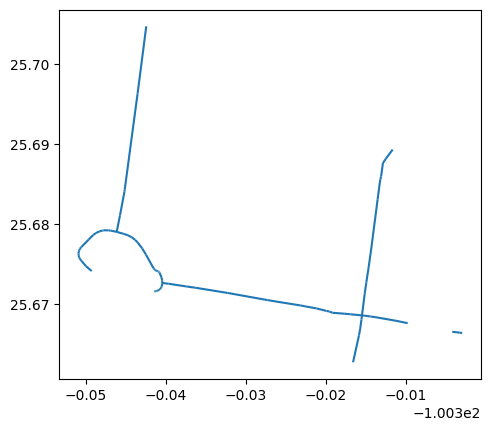

In [23]:
from shapely.geometry import LineString
from shapely.ops import split

# Example: suppose 'gdf' is your GeoDataFrame with multilinestring geometries
# And 'selected_ids' is the list of IDs for geometries you want to join
#selected_ids = ['Av. Benito Juárez','Av. Francisco I. Madero','Av. Simón Bolivar','Licenciado José Benítez','Fray Servando Padre Mier']  # replace with your actual IDs
selected_ids = ['Av. Benito Juárez','Av. Simón Bolivar','Licenciado José Benítez','Fray Servando Padre Mier']  # replace with your actual IDs
selected_geometries = red_vial[red_vial['nombre'].isin(selected_ids)].copy()

# Step 1: Identify Intersections
intersection_points = []
for i, geom1 in enumerate(selected_geometries.geometry):
    for j, geom2 in enumerate(selected_geometries.geometry):
        if i < j:  # Avoid redundant checks
            if geom1.intersects(geom2):
                intersection_points.append(geom1.intersection(geom2))

# Step 2: Split Each Geometry at Intersection Points
split_segments = []
for _, row in selected_geometries.iterrows():
    geometry = row.geometry
    for point in intersection_points:
        if geometry.intersects(point):
            # Split geometry at intersection point and add segments to list
            segments = split(geometry, point).geoms
            split_segments.extend(segments)
        else:
            # Add whole geometry if no intersection
            split_segments.append(geometry)

# Step 3: Filter and Combine Segments
# Only keep the segments that are within the selected IDs and have valid lengths
split_segments = [seg for seg in split_segments if seg.length > 0]

# Create a new LineString combining the segments between intersections
final_geometry = LineString()
for seg in split_segments:
    final_geometry = final_geometry.union(seg)

# Convert final geometry to a GeoDataFrame for visualization or saving
result_gdf = gpd.GeoDataFrame(geometry=[final_geometry])

# Visualize or save result
result_gdf.plot()


In [24]:
# Export final_geometry to a new GeoDataFrame
result_gdf.to_file('nuevaruta.geojson', driver='GeoJSON')

In [25]:
red_publico_mod = red_publico.copy()

# Convert red_publico_mod to a list of dictionaries
red_publico_mod = red_publico_mod.to_dict('records')


new_publico_route = {
    'id': 'rutainventada1',
    'fid': 9991,
    'id_sistema': 240302,
    'id_ruta': 9991,
    'nombre': '9991I',
    'nombre_completo': 'Ruta Inventada 1',
    'grupo': 'None',
    'modalidad': 'None',
    'subsistema': 'None',
    'tipo_unidad': 'None',
    'zona': 'None',
    'longitud_m': final_geometry.length,
    'geometry': final_geometry
}

red_publico_mod.append(new_publico_route)

new_publico = gpd.GeoDataFrame(red_publico_mod)